# character rnn workshop

designed to give some hands on exposure to a chracter rnn

In [3]:
# filesystem and data downloading libraries
import os # for filesystem operations
import requests # for interacting with webpages to get data
from zipfile import ZipFile # unzip in python to keep it all in one place\
import glob # easy file matching

# numerical libraries
import random
import numpy as np # linear algebra library

# text processing libraries
import string
import unicodedata

import time

# deep learning library
import torch # mostly for tensors
import torch.nn as nn # the Neural Networks module from torch. nn by convention

# plotting library
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


## Getting the data

In [4]:
# premade
url = 'https://download.pytorch.org/tutorial/data.zip'

# data download and file managment
if not os.path.isdir('data'):
    os.mkdir('data')
if not os.path.isfile('data/name_data.zip'):
    r = requests.get(url) # download the data
    with open('data/name_data.zip', 'wb') as f:
        f.write(r.content) # save the data to a file

# extract the data
with ZipFile('data/name_data.zip', 'r') as data_zip:
   # Extract all the contents of the data zip file in to the data directory
   data_zip.extractall()

# Look at the folders and the file contents

In [5]:
# print out the data directory contents
# print out some of the file contents
os.listdir('data/names')
with open('data/names/Arabic.txt') as f:
    lines = [line for line in f]
print(len(lines), lines[:10])

2000 ['Khoury\n', 'Nahas\n', 'Daher\n', 'Gerges\n', 'Nazari\n', 'Maalouf\n', 'Gerges\n', 'Naifeh\n', 'Guirguis\n', 'Baba\n']


In [6]:
# set all language files as a list
fnames = glob.glob('data/names/*.txt')
fnames

['data/names/Czech.txt',
 'data/names/German.txt',
 'data/names/Arabic.txt',
 'data/names/Japanese.txt',
 'data/names/Chinese.txt',
 'data/names/Vietnamese.txt',
 'data/names/Russian.txt',
 'data/names/French.txt',
 'data/names/Irish.txt',
 'data/names/English.txt',
 'data/names/Spanish.txt',
 'data/names/Greek.txt',
 'data/names/Italian.txt',
 'data/names/Portuguese.txt',
 'data/names/Scottish.txt',
 'data/names/Dutch.txt',
 'data/names/Korean.txt',
 'data/names/Polish.txt']

## Loading the data

### Helper functions

In [7]:
# string cleaner helper functions
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

def clean_names(name):
    return unicode_to_ascii(name.strip())

In [8]:
# set global variables of the total character set
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
n_letters, all_letters

(57, "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'")

In [9]:
# load the language files into a list of languages and a {language:names} dict
all_languages = [] # list of language names
language_names = {} # dict of key = language, value = list of all names in that language
for fname in fnames:
    with open(fname, 'r') as f:
        language = os.path.basename(fname)[:-4]
        names = [clean_names(line) for line in f]
        all_languages.append(language)
        language_names[language] = names
n_languages = len(all_languages)
print(n_languages, all_languages)

18 ['Czech', 'German', 'Arabic', 'Japanese', 'Chinese', 'Vietnamese', 'Russian', 'French', 'Irish', 'English', 'Spanish', 'Greek', 'Italian', 'Portuguese', 'Scottish', 'Dutch', 'Korean', 'Polish']


## Data as tensors (vectors)

In [10]:
# livecode helper functions
def character_to_tensor(c):
    t = torch.zeros(1, n_letters) # size of tensor (1,n)
    t[0, all_letters.find(c)] = 1 # set to one at index of character
    return t

def word_to_tensor(word):
    w = torch.zeros(len(word), 1, n_letters) # size of tensor (w, 1, n)
    for i, c in enumerate(word):
        w[i,0,all_letters.find(c)] = 1
    return w

In [11]:
# try out some letter/word to tensor examples

In [12]:
character_to_tensor('a').size()#, character_to_tensor('a')

torch.Size([1, 57])

In [13]:
word_to_tensor('abc').size()#, word_to_tensor('abc')

torch.Size([3, 1, 57])

## Sampling the data

In [15]:
# 
def random_choice(l):
    """random selection from list"""
    item = l[random.randint(0,len(l)-1)]
    return item 
    
def random_language_name(language=None):
    """returns all the information for a random language-name pair
    
    args:
        language = if None, select a random language
    """
    if not(language):
        language = random_choice(all_languages)
    name = random_choice(language_names[language])
    
    language_index = all_languages.index(language)
    language_tensor = torch.tensor([language_index], dtype=torch.long)
    name_tensor = word_to_tensor(name)
    return language, name, language_tensor, name_tensor

In [16]:
random_language_name()

('German',
 'Kunkel',
 tensor([1]),
 tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [15]:
for i in range(10):
    lang, name, lang_t, name_t = random_language_name()
    print("language: ", lang,  lang_t, "name: ", name, name_t.size())

language:  Irish tensor([8]) name:  Desmond torch.Size([7, 1, 57])
language:  Russian tensor([6]) name:  Zhadanovsky torch.Size([11, 1, 57])
language:  Vietnamese tensor([5]) name:  Luong torch.Size([5, 1, 57])
language:  Japanese tensor([3]) name:  Okimoto torch.Size([7, 1, 57])
language:  Czech tensor([0]) name:  Egr torch.Size([3, 1, 57])
language:  Korean tensor([16]) name:  Rhee torch.Size([4, 1, 57])
language:  Irish tensor([8]) name:  Seaghdha torch.Size([8, 1, 57])
language:  Portuguese tensor([13]) name:  Santos torch.Size([6, 1, 57])
language:  Polish tensor([17]) name:  Wojewodzki torch.Size([10, 1, 57])
language:  German tensor([1]) name:  Groel torch.Size([5, 1, 57])


## The network!

This is the specific RNN structure that we want to be building:

![network diagram](network_structure.png)

In [39]:
#livecode
class RNN(nn.Module):
    """This dictates the structure and size of the network"""
    def __init__(self, data_size, hidden_size, output_size):
        """Sets up class attributes (mostly data dimensions) and network layers"""
        super(RNN, self).__init__()
        self.combined_input_size = data_size + hidden_size
        self.hidden_size = hidden_size
        
        # fully connected layers
        self.i2o = nn.Linear(self.combined_input_size, output_size) 
        self.i2h = nn.Linear(self.combined_input_size, hidden_size) 
        
        #softmax to turn output into probability
        self.softmax = nn.Softmax(dim=1) 
    
    def forward(self, x, last_hidden):
        """Describes how data moves through the RNN layers"""
        combined_input = torch.cat([x, last_hidden], dim=1)
        output = self.i2o(combined_input)
        hidden = self.i2h(combined_input)
        output_probabilities = self.softmax(output)
        return output_probabilities, hidden
        

In [40]:
# initialise a RNN
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_languages)

In [41]:
hidden_start = torch.zeros(1,n_hidden)
output, hidden = rnn(character_to_tensor('a'), hidden_start)

In [42]:
output.size() # (1, n_languages)

torch.Size([1, 18])

In [43]:
output 

tensor([[0.0597, 0.0493, 0.0603, 0.0558, 0.0537, 0.0550, 0.0572, 0.0605, 0.0562,
         0.0605, 0.0518, 0.0542, 0.0520, 0.0535, 0.0545, 0.0536, 0.0518, 0.0606]],
       grad_fn=<SoftmaxBackward>)

In [44]:
hidden.size() # (1, n_hidden)

torch.Size([1, 128])

### making sense of model output

In [45]:
# live code
def language_from_output(output):
    """takes output probability vector and returns top language"""
    top_n, top_i = output.topk(1) # gives the top 1 score and index
    index = top_i[0].item() # convert tensor to float
    score = top_n[0].item()
    language = all_languages[index]
    return language, index, score

In [46]:
language_from_output(output)

('Polish', 17, 0.060552533715963364)

## Training

### Predict and update model

In [47]:
criterion = nn.NLLLoss() # negative log likelihood loss. Convention
lr = 0.005 # totally arbitrary starter learning rate

def predict(rnn, name_t):
    """pass each character in an input name tensor through the network"""
    hidden = torch.zeros(1,rnn.hidden_size) # initial zero hidden state
    rnn.zero_grad() # removes all gradients from last time
    # loops over the name, passing the hidden vector along each time
    for i in range(name_t.size(0)):
        output, hidden = rnn(name_t[i], hidden) 
    return output

def train_step(lang_t, name_t):
    """predict language, compare with target, and update model parameters """
    
    output = predict(rnn, name_t)
    
    log_likelihood = torch.log(output) # convert to log cause math
    
    # how wrong are we?
    loss = criterion(log_likelihood, lang_t)
    
    # automagick backpropagation
    loss.backward()
    
    for p in rnn.parameters():
        p.data.add_(-lr, p.grad.data)
    return output, loss.item()

In [48]:
lang, name, lang_t, name_t = random_language_name()
train_step(lang_t, name_t)

(tensor([[0.0511, 0.0539, 0.0599, 0.0528, 0.0521, 0.0492, 0.0631, 0.0585, 0.0526,
          0.0596, 0.0540, 0.0562, 0.0548, 0.0601, 0.0596, 0.0510, 0.0556, 0.0559]],
        grad_fn=<SoftmaxBackward>), 2.954637289047241)

### Training loop

In [49]:
def time_since(start):
    """little helper for pretty timestamping"""
    now = time.time()
    dt = now - start
    mins = int(dt/60)
    return f'{mins:>02}:{dt - mins*60:>05.2f}(m:s)'

In [50]:
def train(rnn, n_iters):
    """loop the train_step and view progress"""
    eval_every = (n_iters//20)
    losses = []
    average_losses = []
    start = time.time()
    for i in range(n_iters):
        lang, name, lang_t, name_t = random_language_name()
        output, loss = train_step(lang_t, name_t)
        losses.append(loss)
        
        if (i+1)%eval_every==0 :
                av_loss = sum(losses[-eval_every:])/eval_every
                average_losses.append(av_loss)
                print(f'iter = {i+1:<6} training time = {time_since(start)} %done = {i/n_iters*100:<5.0f}% loss = {av_loss:<10.4f}')
    return losses, average_losses

#### Training run and performance

In [54]:
losses, average_losses = train(rnn, 10000)

iter = 500    training time = 00:00.76(m:s) %done = 5    % loss = 2.8294    
iter = 1000   training time = 00:01.49(m:s) %done = 10   % loss = 2.8030    
iter = 1500   training time = 00:02.28(m:s) %done = 15   % loss = 2.7807    
iter = 2000   training time = 00:02.99(m:s) %done = 20   % loss = 2.7479    
iter = 2500   training time = 00:03.67(m:s) %done = 25   % loss = 2.7461    
iter = 3000   training time = 00:04.33(m:s) %done = 30   % loss = 2.7212    
iter = 3500   training time = 00:04.97(m:s) %done = 35   % loss = 2.6552    
iter = 4000   training time = 00:05.64(m:s) %done = 40   % loss = 2.5612    
iter = 4500   training time = 00:06.31(m:s) %done = 45   % loss = 2.4750    
iter = 5000   training time = 00:06.98(m:s) %done = 50   % loss = 2.4443    
iter = 5500   training time = 00:07.63(m:s) %done = 55   % loss = 2.4464    
iter = 6000   training time = 00:08.29(m:s) %done = 60   % loss = 2.3675    
iter = 6500   training time = 00:08.97(m:s) %done = 65   % loss = 2.3366    

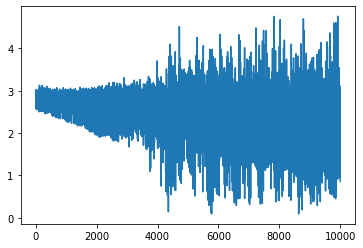

In [55]:
plt.plot(losses)

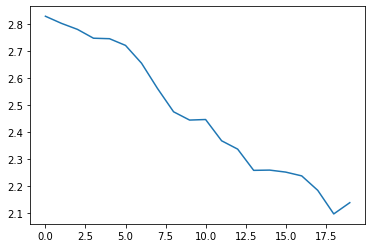

In [56]:
plt.plot(average_losses)

## Measure of success: Confusion

In [29]:
# live code 
def language_confusion(rnn, language, n_samples = 100):
    """evaluate how often the model predicts names from a language correctly"""
    language_predicted = {l:0 for l in all_languages}
    for i in range(n_samples):
        lang, name, lang_t, name_t = random_language_name(language=language)
        output = infer(rnn, name_t)
        guess_lang, guess_index, _ = language_from_output(output)
        language_predicted[guess_lang]+=1
        norm_predictions = {l:count/n_samples for l, count in language_predicted.items()}
    return norm_predictions

In [30]:
preds = language_confusion(rnn, "Polish")
preds, sum([p for p in preds.values()])

({'Czech': 0.06,
  'German': 0.0,
  'Arabic': 0.19,
  'Japanese': 0.14,
  'Chinese': 0.0,
  'Vietnamese': 0.03,
  'Russian': 0.01,
  'French': 0.0,
  'Irish': 0.0,
  'English': 0.0,
  'Spanish': 0.0,
  'Greek': 0.0,
  'Italian': 0.02,
  'Portuguese': 0.0,
  'Scottish': 0.02,
  'Dutch': 0.04,
  'Korean': 0.05,
  'Polish': 0.44},
 1.0000000000000002)

In [ ]:
def evaluate_total_confusion(rnn,samples_per_language=100):
    """Calculates confusion array for all languages"""
    confusion_list = []
    for target_lang in all_languages:
        preds = language_confusion(rnn, target_lang, n_samples=samples_per_language)
        predlist = np.array([[prob for lang, prob in preds.items()]])
        confusion_list.append(predlist)
    return np.concatenate(confusion_list, axis = 0)

In [ ]:
def plot_confusion(confusion):
    """displays a nxn confusion numpy array"""
    # Set up plot
    fig = plt.figure(facecolor='white',figsize=(5,5))
    ax = fig.add_subplot(111)
    
    # add the color scale
    cax = ax.matshow(confusion)
    cbar = fig.colorbar(cax)
    
    # Set up axes
    ax.set_xticklabels([''] + all_languages, rotation=90)
    ax.set_yticklabels([''] + all_languages)

    # Force label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    # labeling
    ax.set_xlabel("predicted languag")
    ax.set_ylabel("target languag")
    cbar.ax.set_ylabel('predicted fraction')
    plt.show()

In [ ]:
confusion = evaluate_total_confusion(samples_per_language = 100)
plot_confusion(confusion)